# Subducted water

Compute how much water is subducted from each contribution of:

- Sediment
- Serpentinite
- Crust
- Lithosphere

The previous notebook __Sources of water.ipynb__ must be run before this notebook. Output grids are written to folders alongside the input grids. These are defined as

```python
water_components = ["Sediment", "Serpentinite", "Crust", "Lithosphere"]
```

Some water is __accreted__ to the overriding plate from the sediments

> __Citation__:
> Vannucchi, P., Morgan, J. P., & Balestrieri, M. L. (2016). Subduction erosion, and the de-construction of continental crust: The Central America case and its global implications. Gondwana Research, 40, 184–198. https://doi.org/10.1016/j.gr.2016.10.001

### Considerations for serpentinisation
Serpentinisation is related to slab bending and takes water into the mantle. We partition 4-15 Mt C/yr (4) to a slab dip of 20-45 degrees, considering average slab dip to be 31 degrees and minimum serpentinisation as 4 Mt C/yr.
We define a linear relationship between serpentinisation (Mt C/yr) and slab dip (degrees) at a subduction segment, with gradient:

$$ \frac{7.5 - 4}{31 - 0} \approx 0.1129$$

Thus, 

$$ C_{\mathrm{seg}} = \frac{0.1129\alpha_{\mathrm{seg}} + 4}{L_0}$$

where $\alpha_{\mathrm{seg}}$ is slab dip at a subduction segment and $L_0$ is the total length of all subduction segments at the present day. We multiply by each segment's subduction convergence to distribute this value of serpentinisation across all global segments.

> __Citations__:
> 1. Vannucchi, P., Morgan, J. P., & Balestrieri, M. L. (2016). Subduction erosion, and the de-construction of continental crust: The Central America case and its global implications. Gondwana Research, 40, 184–198. https://doi.org/10.1016/j.gr.2016.10.001
> 2. Buffett, B. A., & Heuret, A. (2011). Curvature of subducted lithosphere from earthquake locations in the Wadati-Benioff zone. Geochemistry, Geophysics, Geosystems, 12(6), 1–13. https://doi.org/10.1029/2011GC003570
> 3. Faccenda, M., Gerya, T. V., & Burlini, L. (2009). Deep slab hydration induced by bending-related variations in tectonic pressure. Nature Geoscience, 2(11), 790–793. https://doi.org/10.1038/ngeo656
> 4. Kelemen, P. B., & Manning, C. E. (2015). Reevaluating water fluxes in subduction zones, what goes down, mostly comes up. Proceedings of the National Academy of Sciences of the United States of America, 112(30), E3997–E4006. https://doi.org/10.1073/pnas.1507889112

In [1]:
import numpy as np
from gplately import pygplates
import ptt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io import shapereader as shpreader
import netCDF4
import warnings
from scipy import ndimage
import glob, os
from IPython.display import clear_output
import gplately
from slabdip import SlabDipper
from joblib import Parallel, delayed, cpu_count
%matplotlib inline

# common data files
grid_directory = "../Muller2022_InputGrids/"
spreadrate_filename = grid_directory+"SpreadingRate/Muller2022_SPREADING_RATE_grid_{:.1f}Ma.nc"
agegrid_filename = grid_directory+"SeafloorAge/Muller2022_SEAFLOOR_AGE_grid_{:.1f}Ma.nc"

# common variables
extent_globe = [-180, 180, -90, 90]
earth_radius = 6371.0e3
earth_surface_area = 4.0*np.pi*earth_radius**2
tessellation_threshold_radians = np.radians(0.01)

# output grid resolution - should be identical to input grid resolution!
spacingX, spacingY = 0.2, 0.2
resX, resY = int(360./0.2 + 1), int(180./0.2 + 1)
lon_grid = np.arange(extent_globe[0], extent_globe[1]+spacingX, spacingX)
lat_grid = np.arange(extent_globe[2], extent_globe[3]+spacingY, spacingY)
lonq, latq = np.meshgrid(lon_grid,lat_grid)

# reconstruction time steps and spacing
min_time = 0
max_time = 1000
timestep_size = 1

# reversed (start at max_time, end at min_time)
reconstruction_times = np.arange(min_time, max_time+timestep_size, timestep_size)[::-1]

save_output_netcdf = True # !! important
save_output_snapshots = False

In [2]:
gdownload = gplately.download.DataServer("Muller2022", verbose=False)
rotation_model, topology_features, static_polygons = gdownload.get_plate_reconstruction_files()

# Use GPlately's DataServer to get coastlines and continents
coastlines, continents, COBs = gdownload.get_topology_geometries()

model = gplately.PlateReconstruction(rotation_model, topology_features, static_polygons)
gplot = gplately.PlotTopologies(model, coastlines, continents)

In [3]:
def update_progress(progress):
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1
    
    bar_length = 20
    block = int(round(bar_length * progress))

    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)

def surface_area_oblate_spheroid(r1, r2):
    e = np.sqrt(1.0 - r2**2/r1**2)
    return 2.0*np.pi*r1**2*(1.0 + (1.0-e**2)/e * np.arctanh(e))

def My2s(Ma):
    return Ma*3.1536e13

def lat_area_function(latitude_one, latitude_two, longitude_resolution):
    '''
    Calculates the point area of an evenly gridded lat/lon mesh
    Longitude resolution is lon2 - lon1
    '''
    dlat = np.sin(np.radians(latitude_two)) - np.sin(np.radians(latitude_one))
    lat_area = 2 * np.pi * 6371.009e3**2 * np.abs(dlat)/longitude_resolution
    return lat_area

cell_area = lat_area_function(lat_grid, lat_grid+spacingY, lon_grid.size)
cell_area = np.tile(cell_area.reshape(-1,1), lon_grid.size)

In [4]:
# Register colourmaps

from matplotlib.colors import LinearSegmentedColormap
import os

cmap_dir = "../utils/ScientificColourMaps5/"

def get_immediate_subdirectories(a_dir):
    return [name for name in os.listdir(a_dir)
            if os.path.isdir(os.path.join(a_dir, name))]

subdirs = get_immediate_subdirectories(cmap_dir)

cmap_crameri = dict()
for subdir in subdirs:
    print (subdir)
    cm_data = np.loadtxt(cmap_dir+"{}/{}.txt".format(subdir, subdir))
    cmap_crameri[subdir] = LinearSegmentedColormap.from_list(subdir, cm_data)
    cmap_crameri[subdir+'_r'] = LinearSegmentedColormap.from_list(subdir+'_r', cm_data[::-1])
    plt.colormaps.register(cmap=cmap_crameri[subdir])
    plt.colormaps.register(cmap=cmap_crameri[subdir+'_r'])

acton
bamako
batlow
berlin
bilbao
broc
buda
cork
davos
devon
grayC
hawaii
imola
lajolla
lapaz
lisbon
nuuk
oleron
oslo
roma
tofino
tokyo
turku
vik


## Bending-related serpentinisation

The degree of water uptake along the trench-rise is related to plate bending and the opening of normal faults. A low radius of curvature (or high slab dip) results in deeply-penetrating normal faults and serpentinisation than flat slabs.

Here, we calculate slab dip and relate that to serpentinisation and water uptake.

1. Faccenda, M., Burlini, L., Gerya, T. V. & Mainprice, D. Fault-induced seismic anisotropy by hydration in subducting oceanic plates. Nature 455, 1097–1100 (2008).
2. Faccenda, M. Water in the slab: A trilogy. Tectonophysics 614, 1–30 (2014).
3. Ranero, C. R., & Sallarès, V. (2004). Geophysical evidence for hydration of the crust and mantle of the Nazca plate during bending at the north Chile trench. Geology, 32(7), 549–552. https://doi.org/10.1130/G20379.1
4. Ranero, C. R., Phipps Morgan, J., McIntosh, K., & Reichert, C. (2003). Bending-related faulting and mantle serpentinization at the Middle America trench. Nature, 425(6956), 367–373. https://doi.org/10.1038/nature01961


We determine the thickness of the brittle lithosphere from a plate cooling model and subtract the thickness of the crust (8 km). Water forms 13 wt % of serpentinite. Ranero et al 2003's upper limit of serpentinite (15%) results in much too high water content. While others incl. Faccenda ascribe a constant H2O wt % to a varying thickness of uppermost mantle.

Instead, we scale the degree of serpentinite in the brittle part of the mantle lithosphere by slab dip. At slab dip = 0, there is 0 wt % serpentinite. At dip = 90, there is 10 wt% serpentinite. We simply divide the slab dip by 100 to convert to wt %.

<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast


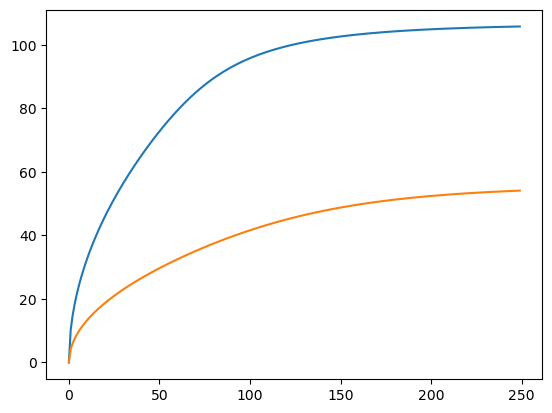

In [5]:
age = np.arange(0, 250)
z_lith = gplately.tools.plate_isotherm_depth(age, 1150)
z_moho = gplately.tools.plate_isotherm_depth(age, 600)


plt.plot(age, z_lith*1e-3,)
plt.plot(age, z_moho*1e-3)

In [6]:
def wt_bending_serpentinite(dip):
    return np.clip(dip, 0, 90)*1.0/9

In [7]:
import os

folder_name = "Muller22_Apr21"

parent_dir = "./H2O_Review_Bundle/{}/".format(folder_name)

# Lithosphere
lithosphere_top_dir = parent_dir+"Reservoirs/Lithosphere/top/"
lithosphere_bottom_dir = parent_dir+ "Reservoirs/Lithosphere/bottom/"

# Crust
crust_bound_dir = parent_dir+"Reservoirs/Crust/bound/"
crust_pore_dir  = parent_dir+"Reservoirs/Crust/pore/"

# Sediments
sediments_bound_dir = parent_dir+"Reservoirs/Sediment/bound/"
sediments_pore_dir = parent_dir+"Reservoirs/Sediment/pore/"


# this relies on a consistent folder structure - don't meddle!

water_components = [lithosphere_bottom_dir, lithosphere_top_dir,
                    crust_bound_dir, crust_pore_dir,
                    sediments_bound_dir, sediments_pore_dir]
headers  = ['lithosphere_bottom', 'lithosphere_top',
            'crust_bound', 'crust_pore',
            'sediment_bound', 'sediment_pore',
            'total']
quantities = ["min", "mean", "max"]

### Initialise SlabDipper object

In [8]:
# Initialise SlabDipper object
dipper = SlabDipper()
dipper.model = model

# Set the filename (including path) of the seafloor age and spreading rate grids
dipper.set_age_grid_filename(agegrid_filename)
dipper.set_spreading_rate_grid_filename(spreadrate_filename)

In [9]:
input_cdf_filename  = "{}/{}/water_{}_grid_{}.nc"
output_cdf_filename = "{}/{}/subducted_water_{}_{}.nc"


def subduct_water(reconstruction_time):
    
    # initialise arrays
    water_subducted = np.zeros((len(water_components), 3))
    water_in_plate  = np.zeros((len(water_components), 3))
    subducted_water_step = np.zeros((resY, resX))
    serpentinite_slab_dip = np.zeros(3)
    
    # calculate slab dip
    df_time = dipper.tessellate_slab_dip(reconstruction_time, tessellation_threshold_radians)

    # remove entries that have "negative" subduction
    # this occurs when the subduction obliquity is greater than 90 degrees
    subduction_convergence = np.clip(df_time['vel'], 0, 1e99)

    # sample AgeGrid
    age_grid = gplately.Raster(filename=agegrid_filename.format(reconstruction_time))
    age_grid.fill_NaNs(inplace=True)
    age_interp = age_grid.interpolate(df_time['lon'], df_time['lat'])
    thickness = gplately.tools.plate_isotherm_depth(age_interp, n=50, tol=1)
    thickness_brittle = gplately.tools.plate_isotherm_depth(age_interp, temp=600, n=50, tol=1)

    # calculate subduction volume rate - m * m * m/yr
    subduction_vol_rate = thickness*df_time['length']*subduction_convergence # integrated along subduction len
    subduction_vol_rate *= 1e-9 # convert m^3/yr to km^3/yr
    
    # area subducted by trenches over 1 Myr
    subduction_surface_area = subduction_convergence * 1e6 * df_time['length']

    # iterate through each water component and find their contribution
    for c, component in enumerate(water_components):
        for i, quantity in enumerate(quantities):
            water_type = headers[c].split('_')[0]
            water_grid = gplately.Raster(filename=input_cdf_filename.format(
                                            component, quantity, water_type, reconstruction_time))

            
            # calculate total water in plate and subducted
            water_in_plate[c,i] = np.nansum(water_grid.data*cell_area)
            
            # sample water grid at subduction zones
            water_grid.fill_NaNs(inplace=True)
            water_interp, (ci, cj) = water_grid.interpolate(df_time['lon'], df_time['lat'], return_indices=True)

            if headers[c].startswith("sediment"):
                # some sediment is scraped off onto overriding plate
                # 0 - 40 % is accreted from 6.8 - 0.0 cm/yr convergence rate
                accretion = np.clip((-0.4/0.068)*subduction_convergence + 0.4, 0.0, 1e99)
                water_interp *= (1.0 - accretion)
                
            if headers[c].startswith("lithosphere_top"):
                # add water from plate bending
                wt_serp = wt_bending_serpentinite(df_time['slab_dip'])/100
                
                # kg/m2 = thickness * H2O wt % * serpentinite wt % * density
                water_dip = (thickness_brittle - 8e3)*(0.13*wt_serp)*2900
                water_dip *= 1e-9 # convert kg/m2 to Mt/m2
                water_interp += water_dip

                serpentinite_slab_dip[i] = (water_dip*subduction_surface_area).sum()

                
            water_subducted[c,i] = (water_interp*subduction_surface_area).sum()

            # place water on subducted grid then smooth.
            # a distance tolerance would be better, but should be OK with a fine subduction tesselation
            subducted_water_step.fill(0.0)
            subducted_water_step[ci,cj] = water_interp
            subducted_water_step = ndimage.grey_dilation(subducted_water_step, (5,5))

            if save_output_netcdf:
                fname = output_cdf_filename.format(component, quantity, water_type, reconstruction_time)
                gplately.grids.write_netcdf_grid(fname, subducted_water_step)


    return water_in_plate, water_subducted, serpentinite_slab_dip

In [10]:
results = Parallel(n_jobs=-2, verbose=1)(
    delayed(subduct_water)(time) for time in reconstruction_times)


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=-2)]: Done  32 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-2)]: Done 182 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-2)]: Done 432 tasks      | elapsed: 18.1min
[Parallel(n_jobs=-2)]: Done 782 tasks      | elapsed: 32.3min
[Parallel(n_jobs=-2)]: Done 1001 out of 1001 | elapsed: 42.0min finished


In [11]:
water_subducted = np.zeros((len(water_components), reconstruction_times.size, 3))
water_in_plate  = np.zeros((len(water_components), reconstruction_times.size, 3))
serpentinite_slab_dip = np.zeros((reconstruction_times.size, 3))

# Employ a double-barrier to clip negative subduction fluxes (we clipped the time series in notebook 1, but
# the grids still retained negativity; re-clip here.)
for t, reconstruction_time in enumerate(reconstruction_times):
    water_in_plate[:,t,:]      = np.clip(np.array(results[t][0]), 0., None)
    water_subducted[:,t,:]     = np.clip(np.array(results[t][1]), 0., None)
    serpentinite_slab_dip[t,:] = np.clip(np.array(results[t][2]), 0., None)
    
#for t, reconstruction_time in enumerate(reconstruction_times):
#    water_in_plate[:,t,:]      = results[t][0]
#    water_subducted[:,t,:]     = results[t][1]
#    serpentinite_slab_dip[t,:] = results[t][2]

### Sum across all netCDFs

To get the cumulative subducted water.

In [12]:
def accumulate_subducted_carbon(reconstruction_time):
    
    subducted_water_components = np.empty((len(water_components), resY, resX))
    
    for c, component in enumerate(water_components):
        water_type = headers[c].split('_')[0]
        subducted_water_grid = gplately.grids.read_netcdf_grid(
            output_cdf_filename.format(component, "mean", water_type, reconstruction_time))
        subducted_water_components[c] = subducted_water_grid
        
    return subducted_water_components

In [13]:
with Parallel(n_jobs=-3, verbose=1) as parallel:
    cumulative_subducted_water = np.zeros((len(water_components), resY, resX))
    
    split_times = np.array_split(reconstruction_times, cpu_count() - 2)
    
    for times in split_times:
        results = parallel(delayed(accumulate_subducted_carbon)(time) for time in times)
    
        for subducted_water_components in results:
            cumulative_subducted_water += subducted_water_components  # synchronization barrier

[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-3)]: Done 126 out of 126 | elapsed:   19.9s finished
[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-3)]: Done 125 out of 125 | elapsed:   17.0s finished
[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-3)]: Done 125 out of 125 | elapsed:   17.7s finished
[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-3)]: Done 125 out of 125 | elapsed:   17.3s finished
[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-3)]: Don

## Plot rasters of cumulative subducted water

In [14]:
# remove artefacts from serpentinite grids
# cumulative_subducted_water[1][1] = ndimage.percentile_filter(cumulative_subducted_water[1][1], 1., 5)

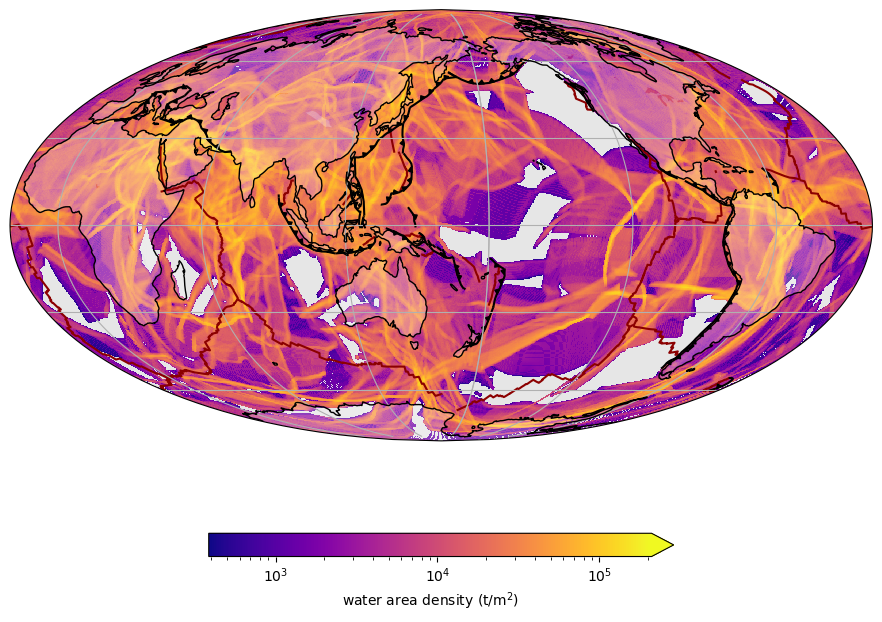

In [15]:
figure_dir = parent_dir+"figures"
os.makedirs(figure_dir, exist_ok=True)

# total subducted water

gplot.time = 0

proj = ccrs.Mollweide(central_longitude=160)
reconstruction_time = 0

total_subducted_water = np.nansum(cumulative_subducted_water, axis=0)




fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111, projection=proj)
ax.set_global()

ax.imshow(np.array([[0.9,0.9],[0.9,0.9]]), extent=[-180,180,-180,180], cmap='gray', vmin=0, vmax=1,
          transform=ccrs.PlateCarree(), zorder=0)
im = ax.imshow(total_subducted_water*1e6, extent=extent_globe, origin='lower', cmap='plasma',
          norm=mcolors.LogNorm(), transform=ccrs.PlateCarree(), interpolation='none')

# add_continents(ax,  facecolor='0.7', zorder=0)
gplot.plot_coastlines(ax, color='w', alpha=0.25, zorder=2)
gplot.plot_ridges_and_transforms(ax, color='DarkRed', linewidth=1.5, zorder=2)
# add_quiver(ax, reconstruction_time, color='k', alpha=0.33, zorder=3)
gplot.plot_trenches(ax, color='k', zorder=2)
gplot.plot_subduction_teeth(ax, color='k', zorder=2)

ax.coastlines(zorder=3)
ax.gridlines()
fig.colorbar(im, shrink=0.4, label='water area density (t/m$^2$)', extend='max', orientation='horizontal')
fig.savefig(figure_dir+"/cumulative_subducted_water_total.pdf", dpi=300, bbox_inches='tight')

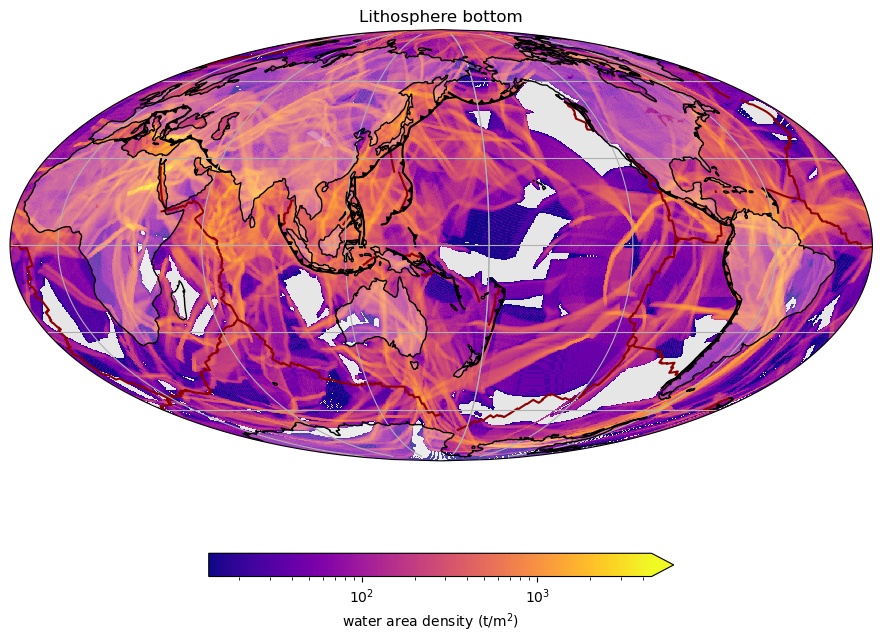

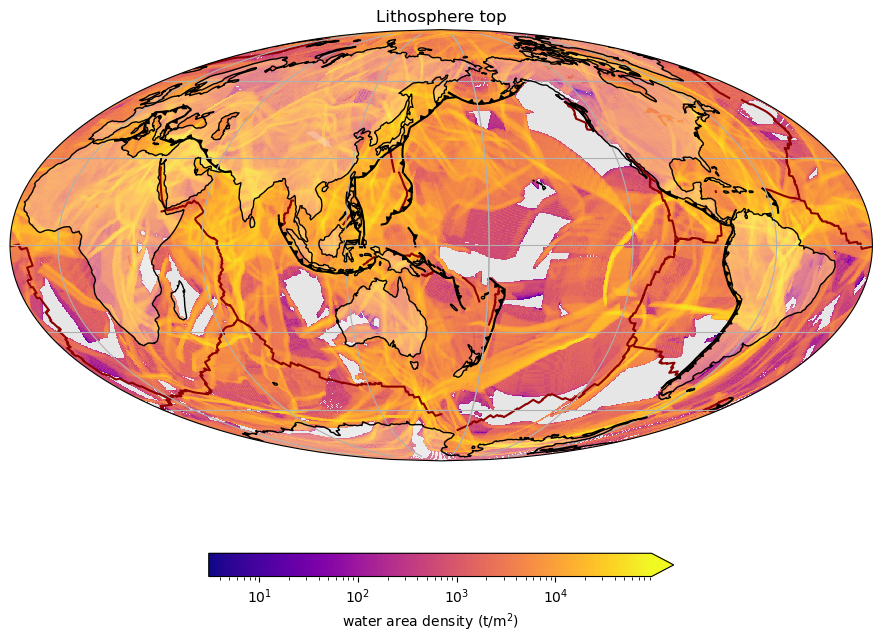

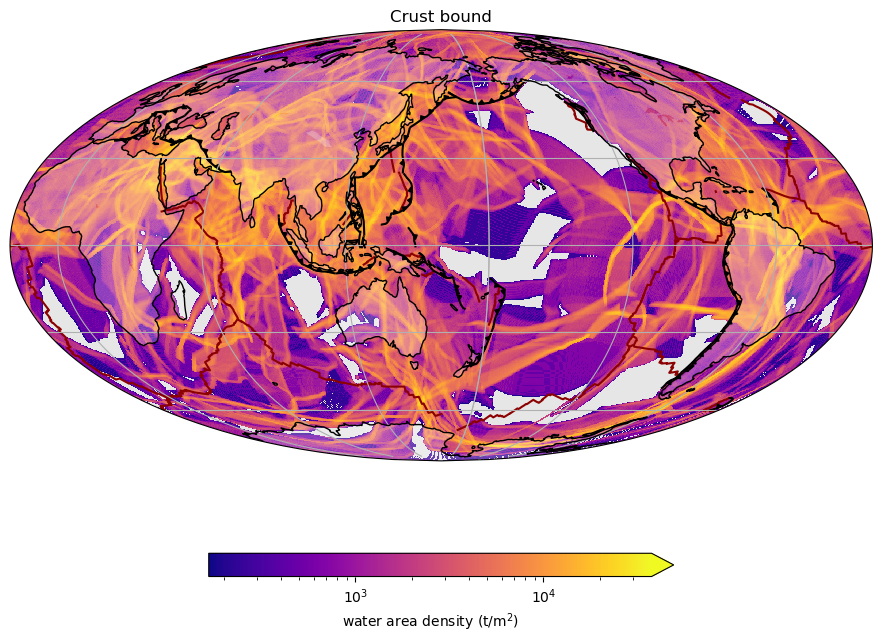

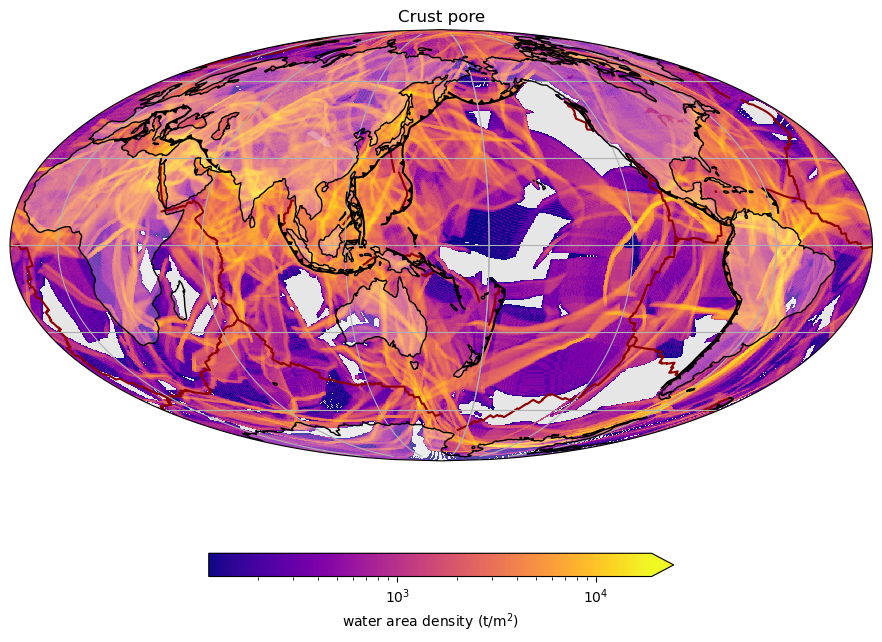

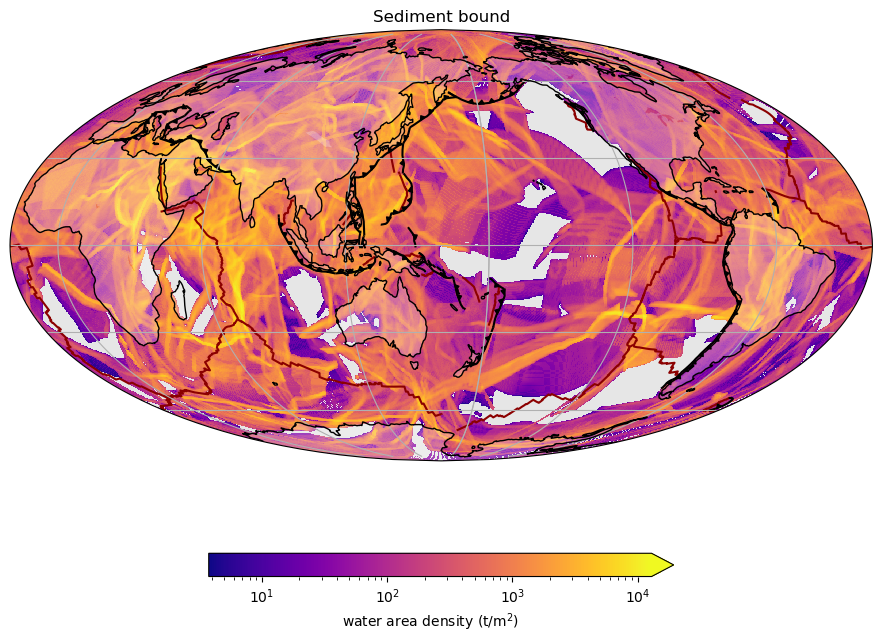

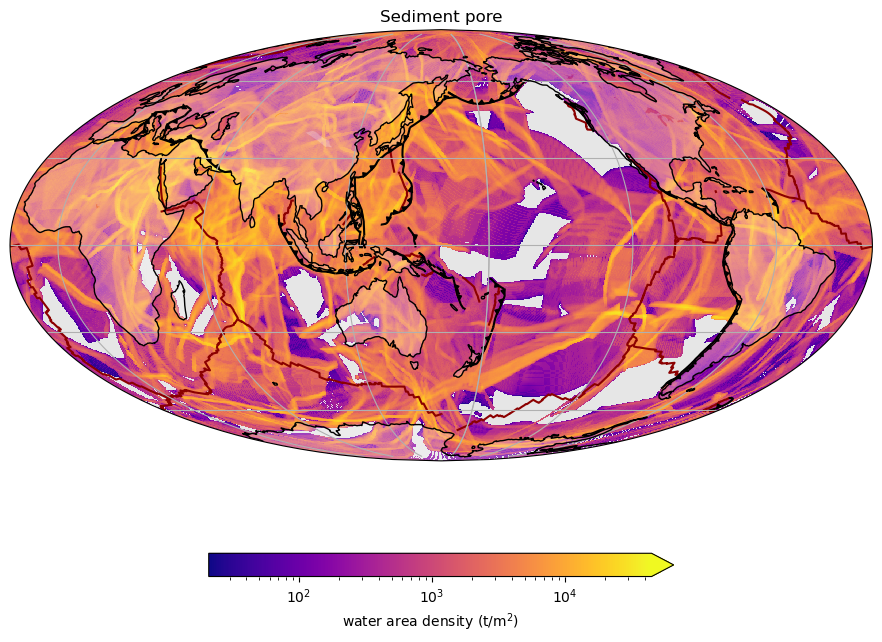

In [16]:
# plot rasters of each water contribution

for c, component in enumerate(water_components):
    
    title = headers[c].replace('_', ' ')
    title = title.capitalize()
    
    fig = plt.figure(figsize=(15,8))
    ax = fig.add_subplot(111, projection=proj, title=title)
    ax.set_global()

    ax.imshow(np.array([[0.9,0.9],[0.9,0.9]]), extent=[-180,180,-180,180], cmap='gray', vmin=0, vmax=1,
              transform=ccrs.PlateCarree(), zorder=0)
    im = ax.imshow(cumulative_subducted_water[c]*1e6, extent=extent_globe, origin='lower', cmap='plasma',
                   norm=mcolors.LogNorm(), transform=ccrs.PlateCarree(), zorder=1, interpolation='none')
    
    # add_continents(ax,  facecolor='0.7', zorder=0)
    gplot.plot_coastlines(ax, color='w', alpha=0.25, zorder=2)
    gplot.plot_ridges_and_transforms(ax, color='DarkRed', linewidth=1.5, zorder=2)
    # add_quiver(ax, reconstruction_time, color='k', alpha=0.33, zorder=3)
    gplot.plot_trenches(ax, color='k', zorder=2)
    gplot.plot_subduction_teeth(ax, color='k', zorder=2)

    ax.coastlines(zorder=3)
    ax.gridlines()
    fig.colorbar(im, shrink=0.4, label='water area density (t/m$^2$)', extend='max', orientation='horizontal')
    fig.savefig(figure_dir+"/cumulative_subducted_water_{}.pdf".format(headers[c]), dpi=300, bbox_inches='tight')

## Plots of water subducted over time

In [17]:
import scipy.ndimage as sn

# This works for smoothing arrays with a (4,1000,3) shape.
def median_filter_3d(array, time_window):
    smooth_result = np.zeros_like(array)
    for c in range(array.shape[0]):
        for i in range(3):
            smooth_result[c,:,i] = sn.median_filter(array[c,:,i], size=time_window)
            
    return smooth_result

# This works for smoothing arrays with a 2D, i.e. (1000,3) shape.
def median_filter_2d(array, time_window):
    smooth_result = np.zeros_like(array)
    for i in range(array.shape[-1]):
        smooth_result[:,i] = sn.median_filter(array[:,i], size=time_window)
    
    return smooth_result

In [18]:
import pandas as pd

time_window = 10 #myr

# sum contributions from various water reservoirs
water_subducted_per_year = (water_subducted*1e-6).sum(axis=0) # convert from Mt C/Ma to Mt C/yr
total_water_subducted = np.cumsum(water_subducted_per_year*1e6, axis=0)

headers  = ['lithosphere_bottom', 'lithosphere_top', 
            'crust_bound', 'crust_pore', 
            'sediment_bound', 'sediment_pore', 
            'bending', 'lithosphere_top (without bending)',
            'total', 'cumulative_total']
quantiles = ['min', 'mean', 'max']

data_out = [
    median_filter_2d(water_subducted[0,:,:]*1e-6, time_window),
    median_filter_2d(water_subducted[1,:,:]*1e-6, time_window),
    median_filter_2d(water_subducted[2,:,:]*1e-6, time_window),
    median_filter_2d(water_subducted[3,:,:]*1e-6, time_window),
    median_filter_2d(water_subducted[4,:,:]*1e-6, time_window),
    median_filter_2d(water_subducted[5,:,:]*1e-6, time_window),
    median_filter_2d(serpentinite_slab_dip*1e-6, time_window),
    median_filter_2d(water_subducted[1,:,:]*1e-6 - serpentinite_slab_dip*1e-6, time_window),
    median_filter_2d(water_subducted_per_year, time_window),
    median_filter_2d(total_water_subducted, time_window)
]


index = pd.MultiIndex.from_product([headers, quantiles])
df = pd.DataFrame(np.column_stack(data_out), columns=index, index=reconstruction_times)
df.to_csv(figure_dir+'/02-subducted-water.csv', index_label='Age (Ma)')

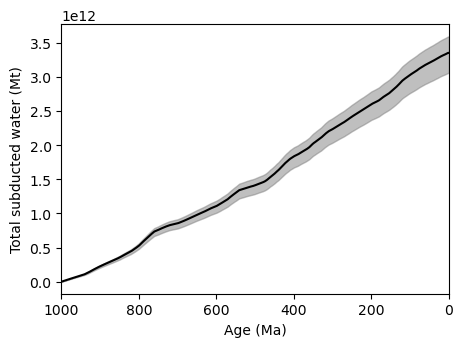

In [19]:
time_window = 10
# total_water_subducted = np.cumsum(np.flipud(water_subducted_per_year), axis=0)[::-1]


fig = plt.figure(figsize=(5,3.5))
ax = fig.add_subplot(111, xlabel='Age (Ma)', ylabel='Total subducted water (Mt)', xlim=[1000,0])


ax.fill_between(reconstruction_times,
                sn.median_filter(total_water_subducted[:,0], size=time_window),
                sn.median_filter(total_water_subducted[:,2], size=time_window),
                color='0.5', alpha=0.5, label='Uncertainty')
ax.plot(reconstruction_times, sn.median_filter(total_water_subducted[:,1], size=time_window), 'k', label='Mean')

fig.savefig(figure_dir+"/total_subducted_water.pdf", bbox_inches='tight', dpi=300)
fig.savefig(figure_dir+"/total_subducted_water.svg", bbox_inches='tight', dpi=300)
fig.savefig(figure_dir+"/total_subducted_water.png", bbox_inches='tight', dpi=300)


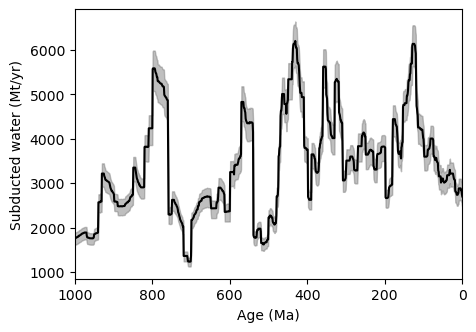

In [20]:
fig = plt.figure(figsize=(5,3.5))
ax = fig.add_subplot(111, xlabel='Age (Ma)', ylabel='Subducted water (Mt/yr)', xlim=[1000,0])

ax.fill_between(reconstruction_times,
                sn.median_filter(water_subducted_per_year[:,0], size=time_window),
                sn.median_filter(water_subducted_per_year[:,2], size=time_window),
                color='0.5', alpha=0.5, label='Uncertainty')
ax.plot(reconstruction_times, sn.median_filter(water_subducted_per_year[:,1], size=time_window), 'k', label='Mean')

fig.savefig(figure_dir+"/subducted_water_per_year.pdf", bbox_inches='tight', dpi=300)
fig.savefig(figure_dir+"/subducted_water_per_year.svg", bbox_inches='tight', dpi=300)
fig.savefig(figure_dir+"/subducted_water_per_year.png", bbox_inches='tight', dpi=300)

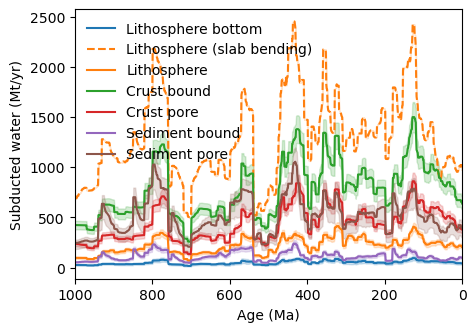

In [21]:
# compare each contribution

fig = plt.figure(figsize=(5,3.5))
ax = fig.add_subplot(111, xlabel='Age (Ma)', ylabel='Subducted water (Mt/yr)', xlim=[1000,0])


for c, component in enumerate(water_components):
    
    label = headers[c].replace('_', ' ')
    label = label.capitalize()

    if headers[c].startswith("lithosphere_top"):

        ax.fill_between(reconstruction_times,
                sn.median_filter(serpentinite_slab_dip[:,0], size=time_window)*1e-6,
                sn.median_filter(serpentinite_slab_dip[:,2], size=time_window)*1e-6,
                color='C{}'.format(c), alpha=0.2)
        ax.plot(reconstruction_times, sn.median_filter(serpentinite_slab_dip[:,1], size=time_window)*1e-6, c="C{}".format(c),
                linestyle='--',
                label='Lithosphere (slab bending)')

        
        ax.fill_between(reconstruction_times,
                        sn.median_filter(water_subducted[c,:,0] - serpentinite_slab_dip[:,0], size=time_window)*1e-6,
                        sn.median_filter(water_subducted[c,:,2] - serpentinite_slab_dip[:,2], size=time_window)*1e-6,
                        color='C{}'.format(c), alpha=0.2)
        ax.plot(reconstruction_times, sn.median_filter(water_subducted[c,:,1] - serpentinite_slab_dip[:,1], size=time_window)*1e-6,
                c="C{}".format(c), label='Lithosphere')



    else:
        ax.fill_between(reconstruction_times,
                        sn.median_filter(water_subducted[c,:,0]*1e-6, size=time_window),
                        sn.median_filter(water_subducted[c,:,2]*1e-6, size=time_window),
                        color='C{}'.format(c), alpha=0.2)
        ax.plot(reconstruction_times, sn.median_filter(water_subducted[c,:,1]*1e-6, size=time_window), c="C{}".format(c), label=label)
    
ax.legend(frameon=False)
fig.savefig(figure_dir+"/water_subducted_comparison_sameaxes.pdf", bbox_inches='tight', dpi=300)
fig.savefig(figure_dir+"/water_subducted_comparison_sameaxes.svg", bbox_inches='tight', dpi=300)
fig.savefig(figure_dir+"/water_subducted_comparison_sameaxes.png", bbox_inches='tight', dpi=300)

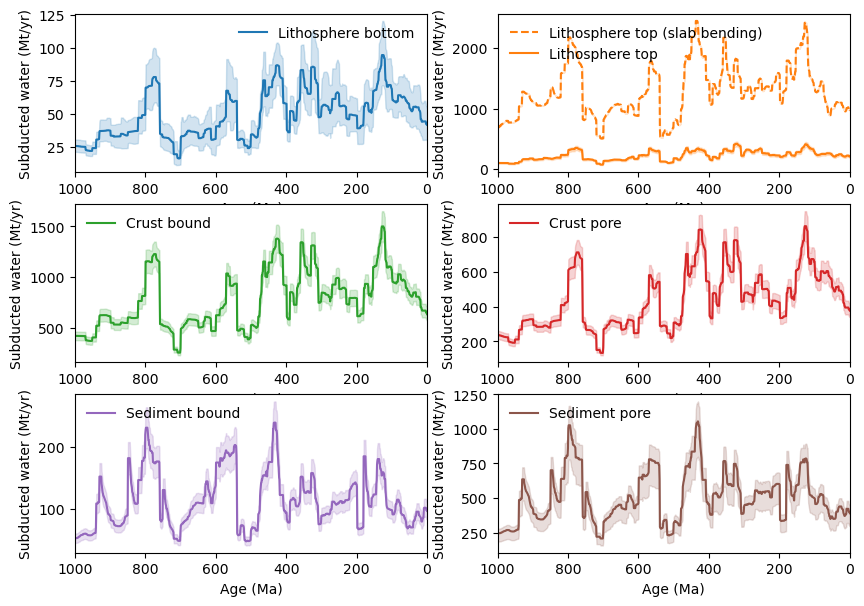

In [22]:
# compare each contribution (separate axes)

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3,2, figsize=(10,7))

for c, ax in enumerate([ax1,ax2,ax3,ax4,ax5,ax6]):
    
    label = headers[c].replace('_', ' ')
    label = label.capitalize()

    if headers[c].startswith("lithosphere_top"):

        ax.fill_between(reconstruction_times,
                sn.median_filter(serpentinite_slab_dip[:,0], size=time_window)*1e-6,
                sn.median_filter(serpentinite_slab_dip[:,2], size=time_window)*1e-6,
                color='C{}'.format(c), alpha=0.2)
        ax.plot(reconstruction_times, sn.median_filter(serpentinite_slab_dip[:,1], size=time_window)*1e-6, c="C{}".format(c),
                linestyle='--',
                label='Lithosphere top (slab bending)')

        
        ax.fill_between(reconstruction_times,
                        sn.median_filter(water_subducted[c,:,0] - serpentinite_slab_dip[:,0], size=time_window)*1e-6,
                        sn.median_filter(water_subducted[c,:,2] - serpentinite_slab_dip[:,2], size=time_window)*1e-6,
                        color='C{}'.format(c), alpha=0.2)
        ax.plot(reconstruction_times, sn.median_filter(water_subducted[c,:,1] - serpentinite_slab_dip[:,1], size=time_window)*1e-6,
                c="C{}".format(c), label='Lithosphere top')



    else:
        ax.fill_between(reconstruction_times,
                        sn.median_filter(water_subducted[c,:,0]*1e-6, size=time_window),
                        sn.median_filter(water_subducted[c,:,2]*1e-6, size=time_window),
                        color='C{}'.format(c), alpha=0.2)
        ax.plot(reconstruction_times, sn.median_filter(water_subducted[c,:,1]*1e-6, size=time_window), c="C{}".format(c), label=label)


    ax.set_xlim(1000,0)
    ax.set_xlabel('Age (Ma)')
    ax.set_ylabel('Subducted water (Mt/yr)')
    ax.legend(frameon=False)

fig.savefig(figure_dir+"/water_subducted_comparison.pdf", bbox_inches='tight', dpi=300)
fig.savefig(figure_dir+"/water_subducted_comparison.svg", bbox_inches='tight', dpi=300)
fig.savefig(figure_dir+"/water_subducted_comparison.png", bbox_inches='tight', dpi=300)

## Plot of plate influx

Now we know the subduction flux, we can compute plate influx.

$\dot{W}_{\mathrm{inplate}} = \dot{W}_{\mathrm{plate}} + \dot{W}_{\mathrm{mantle}}$

In [23]:
time_window = 10 # Myr

#water_plate_influx = sn.median_filter(np.gradient(water_in_plate, axis=1), 1., axis=1)
smooth_water_in_plate = median_filter_3d(
        water_in_plate[:,::-1,:],
        time_window
    )

# water_plate_influx += sn.median_filter(water_subducted, 1., axis=1)
water_plate_influx_without_subduction = median_filter_3d(
    np.gradient(smooth_water_in_plate, 1.0, axis=1)[:,::-1,:],
    time_window
)

# Clip all plate influxes below 0. 
water_plate_influx_without_subduction = np.clip(water_plate_influx_without_subduction, 0., None)

water_plate_influx = water_plate_influx_without_subduction + median_filter_3d(water_subducted, time_window)

total_water_plate_influx = water_plate_influx.sum(axis=0)

headers  = ['lithosphere_bottom', 'lithosphere_top',
            'crust_bound', 'crust_pore',
            'sediment_bound', 'sediment_pore', 
            'total']
quantiles = ['min', 'mean', 'max']

data_out = [
    water_plate_influx[0,:,:]*1e-6,
    water_plate_influx[1,:,:]*1e-6,
    water_plate_influx[2,:,:]*1e-6,
    water_plate_influx[3,:,:]*1e-6,
    water_plate_influx[4,:,:]*1e-6,
    water_plate_influx[5,:,:]*1e-6,
    total_water_plate_influx*1e-6
]


index = pd.MultiIndex.from_product([headers, quantiles])
df = pd.DataFrame(np.column_stack(data_out), columns=index, index=reconstruction_times)
df.to_csv(figure_dir+'/02-plate-influx.csv', index_label='Age (Ma)')


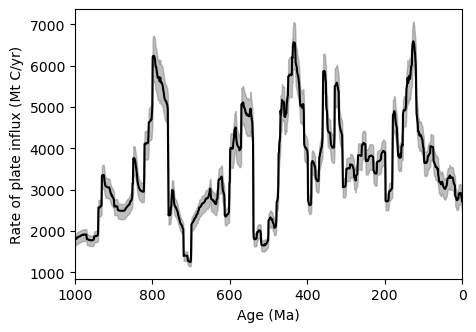

In [24]:
fig = plt.figure(figsize=(5,3.5))
ax = fig.add_subplot(111, xlabel='Age (Ma)', ylabel='Rate of plate influx (Mt C/yr)', xlim=[1000,0])

ax.fill_between(reconstruction_times,
                total_water_plate_influx[:,0]*1e-6,
                total_water_plate_influx[:,2]*1e-6,
                color='0.5', alpha=0.5, label='Uncertainty')

ax.plot(reconstruction_times, total_water_plate_influx[:,1]*1e-6, 'k', label='Mean')

fig.savefig(figure_dir+"/plate_influx.pdf", bbox_inches='tight', dpi=300)

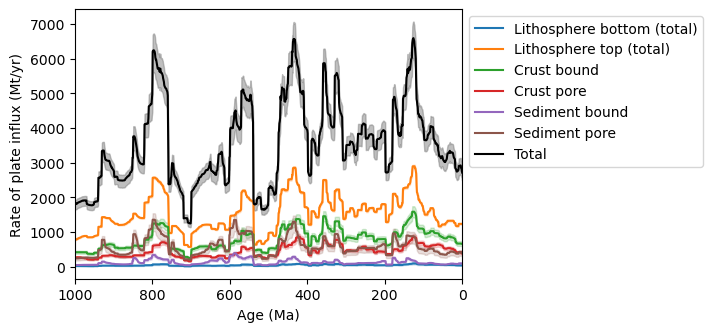

In [25]:
fig = plt.figure(figsize=(5,3.5))
ax = fig.add_subplot(111, xlabel='Age (Ma)', ylabel='Rate of plate influx (Mt/yr)', xlim=[1000,0])
# ax.set_yscale('log')




for c, component in enumerate(water_components):
    
    label = headers[c].replace('_', ' ')
    label = label.capitalize()
    
    if headers[c].startswith('lithosphere'):
        label += ' (total)'

    ax.fill_between(reconstruction_times,
                    sn.median_filter(water_plate_influx[c,:,0], size=time_window)*1e-6,
                    sn.median_filter(water_plate_influx[c,:,2], size=time_window)*1e-6,
                    color='C{}'.format(c), alpha=0.2)
    ax.plot(reconstruction_times, sn.median_filter(water_plate_influx[c,:,1], size=time_window)*1e-6,
            c="C{}".format(c), label=label)


ax.fill_between(reconstruction_times,
                total_water_plate_influx[:,0]*1e-6,
                total_water_plate_influx[:,2]*1e-6,
                color='0.5', alpha=0.5)
ax.plot(reconstruction_times, total_water_plate_influx[:,1]*1e-6, 'k', label='Total')
ax.legend(bbox_to_anchor=(1,1))

fig.savefig(figure_dir+"/plate_influx_comparison_sameaxes.pdf", bbox_inches='tight', dpi=300)

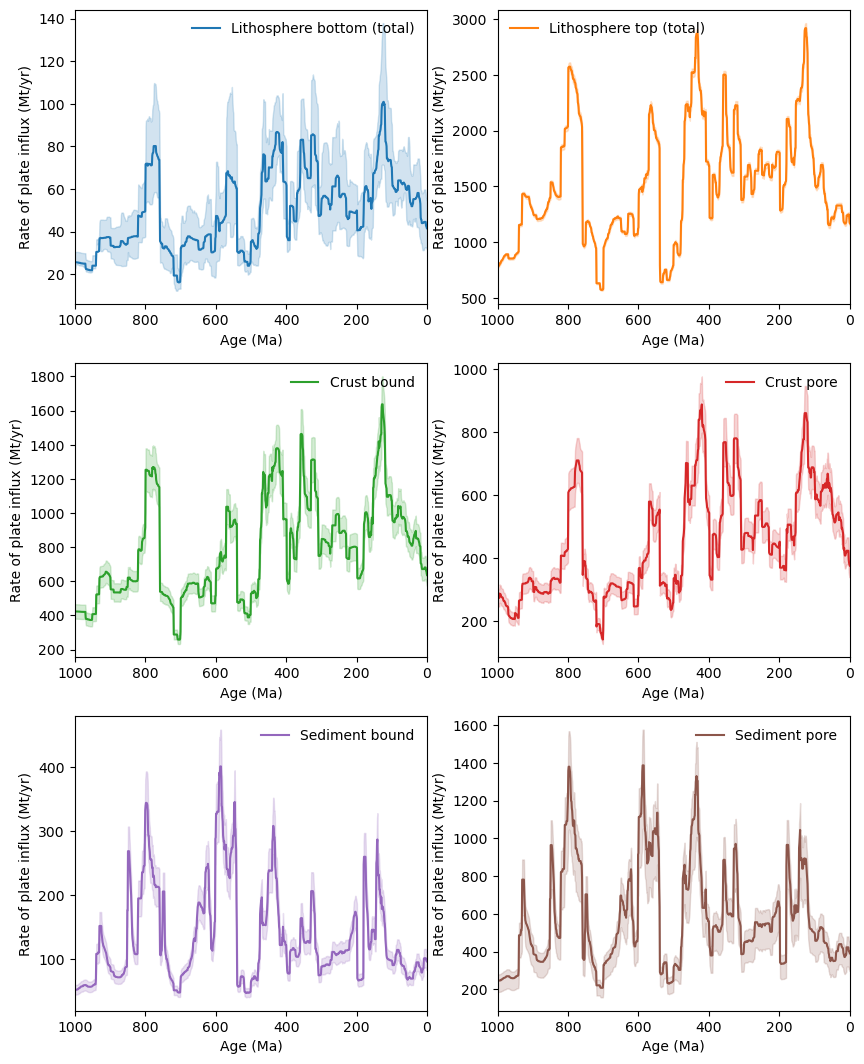

In [26]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3,2, figsize=(10,13))

for c, ax in enumerate([ax1,ax2,ax3,ax4,ax5,ax6]):
    
    label = headers[c].replace('_', ' ')
    label = label.capitalize()
    
    ax.fill_between(reconstruction_times,
                    water_plate_influx[c,:,0]*1e-6,
                    water_plate_influx[c,:,2]*1e-6,
                    color='C{}'.format(c), alpha=0.2)

    if headers[c].startswith('lithosphere'):
        label += ' (total)'
    ax.plot(reconstruction_times, water_plate_influx[c,:,1]*1e-6, c="C{}".format(c), label=label)
    
    ax.set_xlim(1000,0)
    
    #if c == 0:
        #ax.set_ylim(0, 150)
    """
    elif c == 4:
        ax.set_ylim(0, 500)
    elif c == 5:
        ax.set_ylim(0, 1500)
    """
    ax.set_xlabel('Age (Ma)')
    ax.set_ylabel('Rate of plate influx (Mt/yr)')
    ax.legend(frameon=False)
    
    
fig.savefig(figure_dir+"/plate_influx_comparison.pdf", bbox_inches='tight', dpi=300)

## 